**Proposta nova:**
- Uso de LLM para reescrita de politeness e avaliação da reescrita utilizando LLM e algoritmos de aprendizado de máquina.

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install --upgrade numpy
# %pip install seaborn
# %pip install scikit-learn
# %pip install ipywidgets
# %pip install tensorflow
# %pip install --upgrade gensim
# %pip install python-dotenv
# %pip install openai

## runtime compatibility problems (have to run even after install requirements.txt):
# %pip install tf-keras 
# %pip install evaluate
# %pip install accelerate

---

### Activate venv:

In [2]:
## Activate python venv:

# !python -m venv .venv
# Then, select the Jupyter kernel to use the venv, then execute the call below

In [3]:
## Install requirements in the .venv
# %pip install -r requirements.txt

In [4]:
## In case of updating requirements
# %pip freeze > requirements.txt

---
## > Imports

In [180]:
import pandas as pd
import os
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import clear_output
from pprint import pprint
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer, TextClassificationPipeline
import numpy as np
import evaluate
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset 
import torch 
from datetime import date
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import json
from tqdm import tqdm  # For progress bar
from imblearn.over_sampling import SMOTE # resampling

load_dotenv()

OPENAI_PROJECT = os.getenv("OPENAI_PROJECT_ID")
OPENAI_APIKEY = os.getenv("OPENAI_APIKEY")

## ~40 sec load

---
### Dataframe:

In [6]:
path = 'PolitenessDataset-FULL.csv'

# Original Dataframe
OriginalPolitenessDF = pd.read_csv(path)
# print('Data Stats:', OriginalPolitenessDF.describe())

# Experiments Dataframe
TargetDf = OriginalPolitenessDF.copy()

TargetDf.head(4)

,Venue,Review ID,review,Tone,Review URL
0,ShitMyReviewerSay,NaN,"It is early in the year, but difficult to imag...",2,NaN
1,ShitMyReviewerSay,NaN,You do not use the empirical data for the anal...,2,NaN
2,ShitMyReviewerSay,NaN,I understand that Wikipedia is not the best so...,3,NaN
3,ShitMyReviewerSay,NaN,Reviewer #1: 'The project can hardly be descri...,3,NaN


In [7]:
# Basic Transformations:

# Codificação
TargetDf['CodeVenue'] = TargetDf['Venue'].astype('category').cat.codes
# ReviewId
TargetDf['Index'] = TargetDf.index
# Reorder
TargetDf = TargetDf[['Index', 'CodeVenue', 'review', 'Tone']]
TargetDf.rename(columns={'review': 'RawReview'}, inplace=True)
TargetDf.head()

,Index,CodeVenue,RawReview,Tone
0,0,3,"It is early in the year, but difficult to imag...",2
1,1,3,You do not use the empirical data for the anal...,2
2,2,3,I understand that Wikipedia is not the best so...,3
3,3,3,Reviewer #1: 'The project can hardly be descri...,3
4,4,3,The figures are dishonest and not all that use...,2


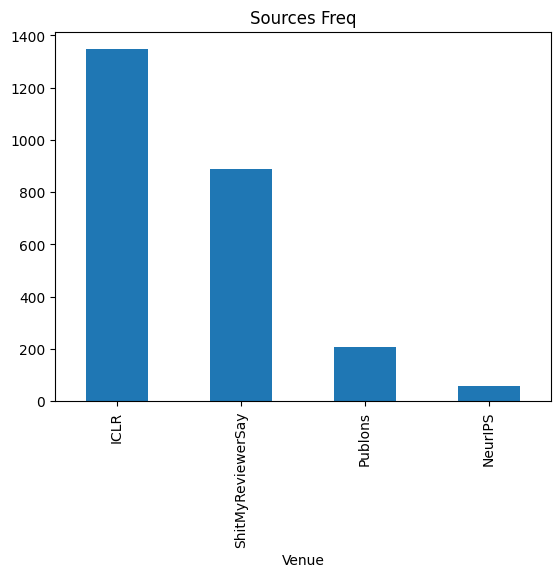

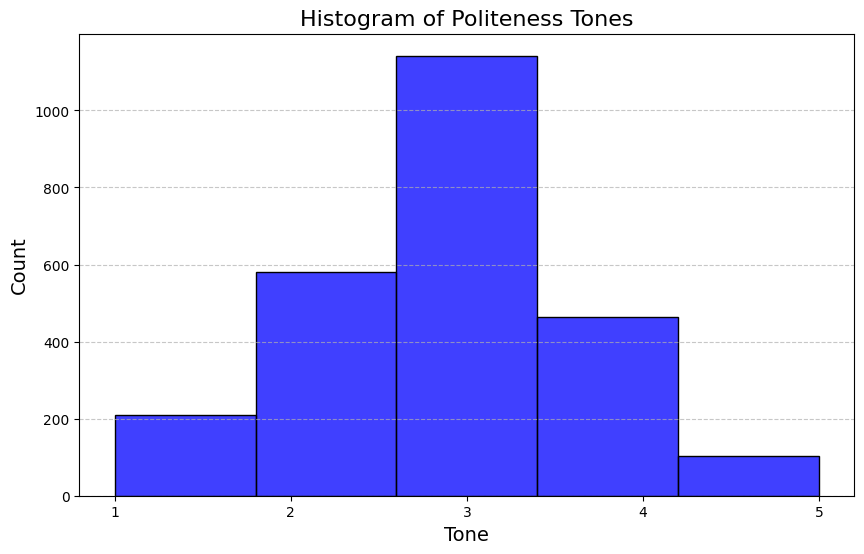

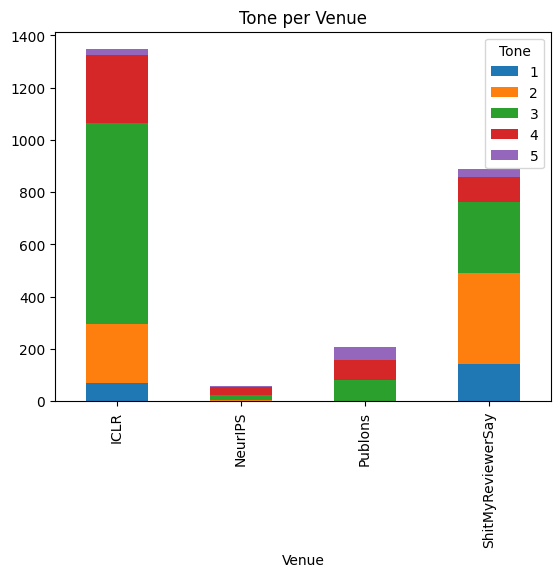

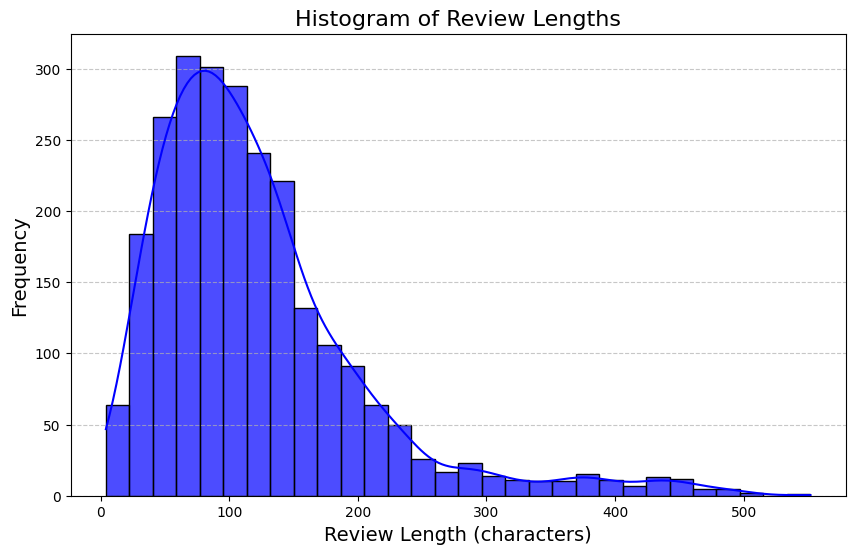

In [8]:
# Some visuals

# Plotting the distribution of the sources
OriginalPolitenessDF['Venue'].value_counts().plot(title='Sources Freq', kind='bar')
plt.show()

# Tone distribution
plt.figure(figsize=(10, 6))
sns.histplot(OriginalPolitenessDF['Tone'], bins=5, fill=True, color='blue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.title("Histogram of Politeness Tones", fontsize=16)
plt.xlabel("Tone", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Plot tone per venue, stacked
OriginalPolitenessDF.groupby(['Venue', 'Tone']).size().unstack().plot(kind='bar', stacked=True, title='Tone per Venue')
plt.show()

# Lenghts
lengths = TargetDf['RawReview'].str.len()

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True, color='blue', alpha=0.7)  # Seaborn for enhanced visuals
plt.title("Histogram of Review Lengths", fontsize=16)
plt.xlabel("Review Length (characters)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
### Pre Processamento:

In [9]:
def ReviewPreProcess(x: str):
    '''
    Esta função realiza:
    - Conversão para string
    - Remoção de Pontuação
    - Tudo minusculo
    - Remoção de links
    - Remoção de menções
    - Remoção de palavras com números
    - Normalização de espaços
    '''
    
    # Converter para string, caso não seja
    if not isinstance(x, str):
        return ''  # Retorna string vazia para entradas inválidas
    
    new_x = x
    for c in punctuation:
        new_x = new_x.replace(c,'')
    pattern = r"""
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """    
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

# TargetDf.rename(columns={'review': 'raw_review'}, inplace=True)
TargetDf['TransformedReview'] = TargetDf['RawReview'].apply(ReviewPreProcess)
TargetDf

,Index,CodeVenue,RawReview,Tone,TransformedReview
0,0,3,"It is early in the year, but difficult to imag...",2,it is early in the year but difficult to imagi...
1,1,3,You do not use the empirical data for the anal...,2,you do not use the empirical data for the anal...
2,2,3,I understand that Wikipedia is not the best so...,3,i understand that wikipedia is not the best so...
3,3,3,Reviewer #1: 'The project can hardly be descri...,3,reviewer the project can hardly be described...
4,4,3,The figures are dishonest and not all that use...,2,the figures are dishonest and not all that useful
...,...,...,...,...,...
2495,2495,3,The scientific contribution of this paper - if...,2,the scientific contribution of this paper if t...
2496,2496,3,Reviewer 2: The proposal is also poorly writte...,2,reviewer the proposal is also poorly written...
2497,2497,3,The paper could be considered for acceptance g...,3,the paper could be considered for acceptance g...
2498,2498,3,I don't see how your approach has potential to...,2,i dont see how your approach has potential to ...


Len of short reviews: 59


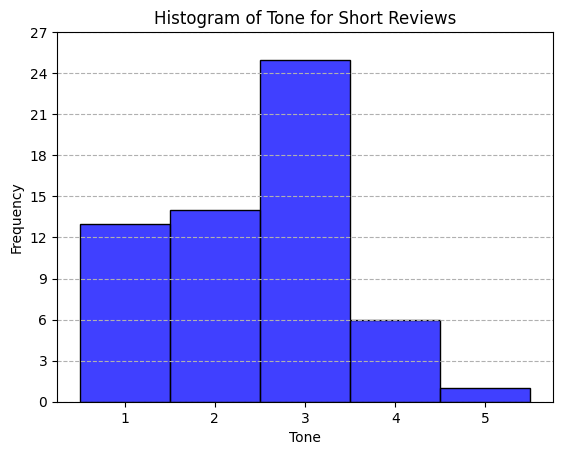

In [10]:
filtered_data = TargetDf[TargetDf['TransformedReview'].str.len() < 20]['Tone']

print('Len of short reviews:', len(filtered_data))

# use sns to create a histogram of the Tone column:
sns.histplot(filtered_data, kde=False, discrete=True, color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Histogram of Tone for Short Reviews')
plt.xlabel('Tone')
plt.ylabel('Frequency')
plt.yticks(range(0, 30, 3))
plt.grid(axis='y', linestyle='--')

# Mostrar o gráfico
plt.show()

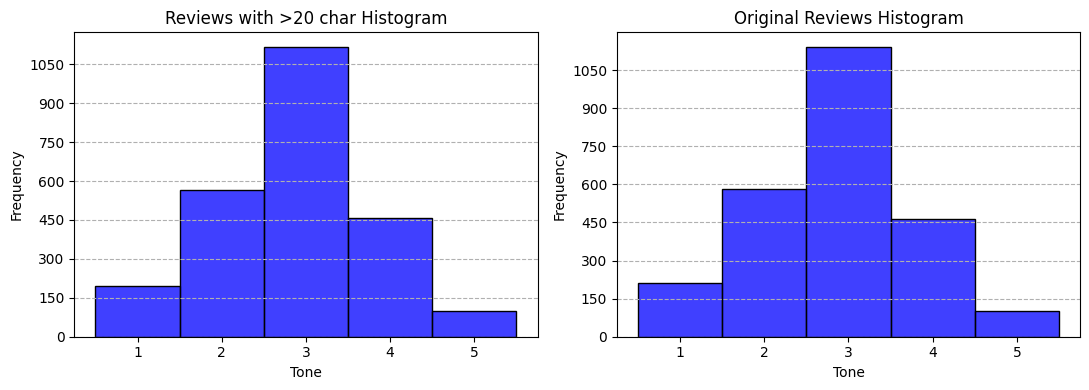

Filtered Dataframe: Tone
3    1117
2     567
4     459
1     197
5     101
Name: count, dtype: int64
Total of Reviews: 2441 

Original Dataframe: Tone
3    1142
2     581
4     465
1     210
5     102
Name: count, dtype: int64
Total of Original Reviews: 2500


In [11]:
# Only keep reviews with more than 20 characters
TargetDf2 = TargetDf[TargetDf['TransformedReview'].str.len() >= 20].copy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  # 1 row, 2 columns

# First subplot: Reviews with >20 characters
sns.histplot(TargetDf2['Tone'], kde=False, discrete=True, color='blue', ax=axes[0])
axes[0].set_title('Reviews with >20 char Histogram')
axes[0].set_xlabel('Tone')
axes[0].set_ylabel('Frequency')
axes[0].set_yticks(range(0, 1200, 150))
axes[0].grid(axis='y', linestyle='--')

# Second subplot: Original Reviews
sns.histplot(TargetDf['Tone'], kde=False, discrete=True, color='blue', ax=axes[1])
axes[1].set_title('Original Reviews Histogram')
axes[1].set_xlabel('Tone')
axes[1].set_ylabel('Frequency')
axes[1].set_yticks(range(0, 1200, 150))
axes[1].grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

# quantity of tones for both dataframes:
print('Filtered Dataframe:', TargetDf2['Tone'].value_counts())
print('Total of Reviews:', len(TargetDf2), '\n')
print('Original Dataframe:', TargetDf['Tone'].value_counts())
print('Total of Original Reviews:', len(TargetDf))

--- 
### Separate Train x Test data: 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(TargetDf2['TransformedReview'], TargetDf2['Tone'], test_size=0.2, random_state=42)

y_train = y_train - 1
y_test = y_test - 1

---
### Fine-Tune BERT:

#### Load Model (Already Fine-Tuned):

In [13]:
# Load from local
local_path = 'bert-treined261224'
model_trained = AutoModelForSequenceClassification.from_pretrained(local_path)
tokenizer = AutoTokenizer.from_pretrained(local_path)

#### Fine-Tune Model Pipeline:
**IMPORTANT:**\
Here, <font color='orangered'>**only fine-tune**</font> the model (run cells below) if: 
- Desired: For new experiments
- Don't have a fine-tuned model saved

In [ ]:
# model_base = 'bert-base-uncased'                          ## >>> Uncomment this in case of fine-tuning the model (commented here to avoid running everything)
tokenizer = AutoTokenizer.from_pretrained(model_base) 

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=128,  # Adjust this as needed
            return_tensors="pt",
        )
        # Return a dictionary with the required fields
        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),  # Label tensor
        }

# Prepare the datasets
train_dataset = CustomDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
output_dir = './bert'
training_args = TrainingArguments(
    output_dir=output_dir,                    # Nome e diretório do modelo final
    num_train_epochs=3,                       # Número de épocas
    per_device_train_batch_size=8,            # Tamanho do lote (batch) por GPU
    per_device_eval_batch_size=8,             # Tamanho do lote (batch) para validação por GPU
    weight_decay=0.01,                        # Força de decaimento
    logging_dir='./logs',                     # Pasta para salvar logs
    logging_steps=100,                        # Logar a cada N etapas
    eval_strategy='steps',                    # Estratégia de avaliação
    eval_steps=200,                           # Rodar avaliação a cada N etapas
    save_total_limit=2,                       # Salvar apenas os ultimos N checkpoints
    save_steps=200,                           # Salvar checkpoint a cada N etapas.
    load_best_model_at_end=True,              # Carregar o melhor modelo no fim
    metric_for_best_model='accuracy',         # Métrica para encontrar o melhor modelo
)

model = AutoModelForSequenceClassification.from_pretrained(model_base, num_labels=5)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train() ## ~28-31 min

simple_date = date.today().strftime('%d%m%y')
trainer.save_model('bert-treined'+simple_date)

#### Test the model:

In [ ]:
# New Prediction
pipe = TextClassificationPipeline(model=model_trained, tokenizer=tokenizer)

# Sample prediction:
prediction = pipe("This article looks like shit", top_k=None)
prediction

# Expected results:
# [{'label': 'LABEL_0', 'score': 0.6987417936325073},
#  {'label': 'LABEL_1', 'score': 0.25321346521377563},
#  {'label': 'LABEL_4', 'score': 0.018354864791035652},
#  {'label': 'LABEL_3', 'score': 0.01649334840476513},
#  {'label': 'LABEL_2', 'score': 0.013196535408496857}]

[{'label': 'LABEL_0', 'score': 0.6987417936325073},
 {'label': 'LABEL_1', 'score': 0.25321346521377563},
 {'label': 'LABEL_4', 'score': 0.018354864791035652},
 {'label': 'LABEL_3', 'score': 0.01649334840476513},
 {'label': 'LABEL_2', 'score': 0.013196535408496857}]

In [ ]:
# Label correctly the results
def ClassificationResult(classf_results: list, review_text: str, index, prediction):
    final_result = {'label':'', 'score':0} # starts with zero
    # Classification based on higher score:
    for result in prediction:
        if round(result['score'],5) > final_result['score']:
            final_result = {
                'label': result['label'],
                'score': round(result['score'],5)}
    # Append classf_results   
    match final_result['label']:
        case 'LABEL_0': # HI
            classf_results.append({
                'review':review_text,
                'label':'1',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_1': # I
            classf_results.append({
                'review':review_text,
                'label':'2',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_2': # Neutral
            classf_results.append({
                'review':review_text,
                'label':'3',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_3': # P
            classf_results.append({
                'review':review_text,
                'label':'4',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_4': # HP
            classf_results.append({
                'review':review_text,
                'label':'5',
                'score':final_result['score'],
                'index':index,})

classf_results = [] 
test_dataframe = pd.DataFrame({'review': X_test, 'tone': y_test})

for index, row in test_dataframe.iterrows():
    prediction = pipe(row['review'], top_k=None)
    ClassificationResult(classf_results, row['review'], index, prediction)
## ~ 20s - 3min 

In [21]:
## Test Dataframe
## Preparing for confusion matrix

predicted_dataframe = pd.DataFrame(classf_results)
predicted_dataframe.set_index('index', inplace=True)
predicted_dataframe = pd.concat([test_dataframe, predicted_dataframe[['label','score']]], axis=1)
predicted_dataframe.rename(columns={'label':'bert_predicted_label'}, inplace=True)
predicted_dataframe['tone'] = predicted_dataframe['tone'] + 1
predicted_dataframe

,review,tone,bert_predicted_label,score
2368,all the comments have been successfully addressed,3,4,0.77732
642,the writing is often arrestingly pedestrian,2,4,0.35930
2259,the paper seems wellwritten and technically so...,3,4,0.77032
1643,surely if we reduce overfitting then by defini...,4,3,0.93592
2409,the authors have satisfactorily adressed to re...,4,4,0.78587
...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550
1686,it seems you have exchanged first name and las...,2,2,0.79779
237,it is unclear how this would advance the field...,2,3,0.95192
441,pity about the main thesis,3,2,0.66619


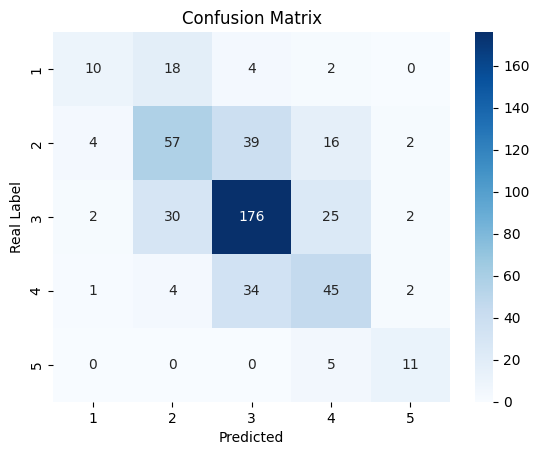

In [22]:
# Define the range of labels explicitly (1 to 5)
label_range = [1, 2, 3, 4, 5]

# Generate the confusion matrix
conf_matrix = confusion_matrix(
    predicted_dataframe['tone'].astype(int), 
    predicted_dataframe['bert_predicted_label'].astype(int), 
    labels=label_range
)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_range, yticklabels=label_range)
plt.xlabel('Predicted')
plt.ylabel('Real Label')
plt.title('Confusion Matrix')
plt.show()

### Rewrite Sentences with OpenAi (GPT 4o):

In [26]:
Sample1 = test_dataframe[test_dataframe['tone'] == 1].iloc[10]['review']
pprint('Sample1: '+Sample1)

# ChatGPT client:
client = OpenAI(
    api_key=OPENAI_APIKEY,
    project=OPENAI_PROJECT
)

PromptClassify = [
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
        {"role": "user", "content":     "I need help with a Peer Review comment.\
                                        in a scale of 1 - 5 classify the comment about it's Politeness.\
                                        How to classify (in a range):\
                                        Highly Impolite (1): Comments containing unnecessarily offensive, sarcastic,\
                                        or disrespectful critiques, using derogatory terms or expressing disdain for the reviewed work.\
                                        Highly Polite (5): Comments explicitly emphasizing positive aspects, using linguistic mitigations,\
                                        direct praise, and respectful language to convey critiques or suggestions.\
                                        Neutral (3) would be a comment that is neither polite nor impolite.\
                                        Bring the rank first, then after a 2 line explanation why, of this comment:"+Sample1},
    ]

PromptRewrite = [
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rewriting impolite comments to be more polite."}, 
        {"role": "user", "content":     "I need help with a comment, Don't lose any content of the comment just rewrite it more politely. \
                                        Don't write anything else in the reply, just the rewritten comment.\
                                        Rewrite more politely: "+Sample1},
    ]


completion = client.chat.completions.create(
    model="gpt-4o",
    # messages = PromptClassify
    messages = PromptRewrite,
    temperature=0.1,
)

# Rewrite Sample:
response = completion.choices[0].message.content
pprint(response)

('Sample1: although finding novel gan applications is an exciting topic i am '
 'not really convinced that ica with the proposed wasserstein gan based '
 'technique fulfills this goal')
('While exploring novel GAN applications is indeed an exciting topic, I am not '
 'entirely convinced that ICA with the proposed Wasserstein GAN-based '
 'technique achieves this objective.')


In [28]:
# Test of BERT Classification of the rewritten comment:

RewritePrediction = pipe(response, top_k=None)
RewritePrediction

[{'label': 'LABEL_1', 'score': 0.5369321703910828},
 {'label': 'LABEL_2', 'score': 0.21113526821136475},
 {'label': 'LABEL_3', 'score': 0.16167257726192474},
 {'label': 'LABEL_0', 'score': 0.0733666867017746},
 {'label': 'LABEL_4', 'score': 0.016893295571208}]

### Rewritten Predictions pipeline:

In [ ]:
## Predictions pipeline:

def RewritePolite(Sample: str):
    PromptRewrite = [
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rewriting impolite comments to be more polite."}, 
        {"role": "user", "content":     "I need help with a comment, Don't lose any content of the comment just rewrite it more politely. \
                                        Don't write anything else in the reply, just the rewritten comment.\
                                        Rewrite more politely: "+Sample},]
    
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages = PromptRewrite)
    
    response = completion.choices[0].message.content
    return response

def PredictTone(review: str):
    prediction = pipe(review, top_k=None)
    return prediction


complete_test_dataframe = predicted_dataframe.copy()
complete_test_dataframe['rewritten_review'] = complete_test_dataframe['review'].apply(RewritePolite) ## ~10 min rodando
complete_test_dataframe

## ~ 10 min

,review,tone,bert_predicted_label,score,rewritten_review
2368,all the comments have been successfully addressed,3,4,0.77732,All the comments have been thoroughly and succ...
642,the writing is often arrestingly pedestrian,2,4,0.35930,The writing sometimes tends to be quite straig...
2259,the paper seems wellwritten and technically so...,3,4,0.77032,The paper appears to be well-written and techn...
1643,surely if we reduce overfitting then by defini...,4,3,0.93592,"Certainly, if we reduce overfitting, it should..."
2409,the authors have satisfactorily adressed to re...,4,4,0.78587,The authors have effectively addressed the rev...
...,...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550,I am curious about our reasoning behind making...
1686,it seems you have exchanged first name and las...,2,2,0.79779,It appears that the first and last names might...
237,it is unclear how this would advance the field...,2,3,0.95192,It is not immediately clear how this might adv...
441,pity about the main thesis,3,2,0.66619,It's unfortunate about the main thesis.


In [ ]:
## BERT Classification of the rewritten reviews:
bert_classf_results_rewritten = [] 

for index, row in complete_test_dataframe.iterrows():
    prediction = pipe(row['rewritten_review'], top_k=None)
    ClassificationResult(bert_classf_results_rewritten, row['rewritten_review'], index, prediction)
    
## ~ 20s

In [31]:
predicted_dataframe2 = pd.DataFrame(bert_classf_results_rewritten)
predicted_dataframe2.set_index('index', inplace=True)
predicted_dataframe2.rename(columns={'label':'bert_rewritten_predicted_label','score':'bert_rewritten_score'}, inplace=True)
complete_test_dataframe = pd.concat([complete_test_dataframe, predicted_dataframe2[['bert_rewritten_predicted_label','bert_rewritten_score']]], axis=1)
complete_test_dataframe

,review,tone,bert_predicted_label,score,rewritten_review,bert_rewritten_predicted_label,bert_rewritten_score
2368,all the comments have been successfully addressed,3,4,0.77732,All the comments have been thoroughly and succ...,4,0.64584
642,the writing is often arrestingly pedestrian,2,4,0.35930,The writing sometimes tends to be quite straig...,3,0.70818
2259,the paper seems wellwritten and technically so...,3,4,0.77032,The paper appears to be well-written and techn...,4,0.66546
1643,surely if we reduce overfitting then by defini...,4,3,0.93592,"Certainly, if we reduce overfitting, it should...",3,0.77478
2409,the authors have satisfactorily adressed to re...,4,4,0.78587,The authors have effectively addressed the rev...,4,0.80835
...,...,...,...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550,I am curious about our reasoning behind making...,2,0.71041
1686,it seems you have exchanged first name and las...,2,2,0.79779,It appears that the first and last names might...,3,0.87540
237,it is unclear how this would advance the field...,2,3,0.95192,It is not immediately clear how this might adv...,3,0.86733
441,pity about the main thesis,3,2,0.66619,It's unfortunate about the main thesis.,2,0.67780


In [32]:
pprint(complete_test_dataframe['bert_predicted_label'].value_counts().sort_index())
pprint(complete_test_dataframe['bert_rewritten_predicted_label'].value_counts().sort_index())

bert_predicted_label
1     17
2    109
3    253
4     93
5     17
Name: count, dtype: int64
bert_rewritten_predicted_label
1      1
2     68
3    219
4    156
5     45
Name: count, dtype: int64


### GPT Classification:

In [54]:
## Classify with GPT-4o:

def GptClassification(Sample: str):
    PromptClassify1 = [
            {"role": "system", "content":   "You are a helpful technical assistant,\
                                            specialist in non violent communication, politeness and all communication matters.\
                                            You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
            {"role": "user", "content":     "I need help with a Peer Review comment.\
                                            in a scale of 1 - 5 classify the comment about it's Politeness.\
                                            How to classify (in a range):\
                                            Highly Impolite (1): Comments containing unnecessarily offensive, sarcastic,\
                                            or disrespectful critiques, using derogatory terms or expressing disdain for the reviewed work.\
                                            Highly Polite (5): Comments explicitly emphasizing positive aspects, using linguistic mitigations,\
                                            direct praise, and respectful language to convey critiques or suggestions.\
                                            Neutral (3) would be a comment that is neither polite nor impolite.\
                                            In a json format: {'label':'_ClassificationResult_', 'explanation':'_Explanation_'} \
                                            Bring up the politeness rating of the comment at the _ClassificationResult_, then after a 2 line explanation why at the _Explanation_, \
                                            of this comment:"+Sample},
        ]
    
    PromptClassify2 = [
            {"role": "system", "content":   "You are a helpful technical assistant,\
                                            specialist in non violent communication, politeness and all communication matters.\
                                            You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
            {"role": "user", "content":     "In a scale of 1 - 5 classify the comment about it's Politeness.\
                                            In a json format: {'label':'_ClassificationResult_', 'explanation':'_Explanation_'} \
                                            Bring up the politeness rating of the comment at the _ClassificationResult_, then after a 2 line explanation why at the _Explanation_, \
                                            of this comment:"+Sample},
        ]
        
    # completion1 = client.chat.completions.create(
    #     model="gpt-4o",
    #     messages = PromptClassify1,
    #     temperature = 0.1
    #     )
    
    completion2 = client.chat.completions.create(
        model="gpt-4o",
        messages = PromptClassify2,
        temperature = 0.1
        )

    # return completion1.choices[0].message.content, completion2.choices[0].message.content
    return completion2.choices[0].message.content

## Function that returns a json from a string in json format
def SimpleFormatting(text):
    '''function that returns a json from a string in json format'''    
    json_string = text.strip('```json').strip()
    return json.loads(json_string)


# Cache results to avoid duplicate API calls
result_cache = {}

## Function to classify with GPT each review
def process_review(review):
    if review in result_cache:
        return result_cache[review]
    try:
        # Call the GPT classification API
        rank1 = GptClassification(review)
        rank1 = SimpleFormatting(rank1)
        result_cache[review] = rank1['label']
        return rank1['label']
    except Exception as e:
        print('Exception at json dump (moving forward):', e)
        return None
## Examples:
# comment = "although finding novel gan applications is an exciting topic i am \
#     not really convinced that ica with the proposed wasserstein gan based \
#     technique fulfills this goal"
# comment = "the writing is often arrestingly pedestrian"

# rewritten_comment = "while exploring novel gan applications is indeed an exciting topic i am not \
#     entirely convinced that the proposed ica with the wasserstein gan based \
#     technique fully achieves this objective."
# rewritten_comment = "The writing tends to be straightforward and uncomplicated."
    
# rank1, rank2 = GptClassification(comment)
# pprint(rank1)
# print('\n')
# pprint(rank2)

In [39]:
## GPT 4o Classification:

df5 = complete_test_dataframe.copy()

# Apply the function to the entire column
tqdm.pandas()  # Initialize tqdm for Pandas
df5['GptClassification:'] = df5['review'].progress_apply(process_review)

## ~15 minutes

 17%|█▋        | 82/489 [02:17<09:43,  1.43s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 23%|██▎       | 111/489 [03:04<10:38,  1.69s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 29%|██▉       | 143/489 [03:57<07:51,  1.36s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 2 column 3 (char 4)


 53%|█████▎    | 260/489 [07:21<05:50,  1.53s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 2 column 3 (char 4)


 68%|██████▊   | 333/489 [09:29<03:48,  1.47s/it]

Exception at json dump (moving forward): Expecting value: line 1 column 1 (char 0)


100%|██████████| 489/489 [14:23<00:00,  1.77s/it]


In [56]:
tqdm.pandas()  # Initialize tqdm for Pandas
df5['GptClassification_rewritten:'] = df5['rewritten_review'].progress_apply(process_review)

  2%|▏         | 10/489 [00:13<11:14,  1.41s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


  6%|▌         | 29/489 [00:51<12:57,  1.69s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


  7%|▋         | 34/489 [00:58<10:18,  1.36s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 17%|█▋        | 81/489 [02:17<09:55,  1.46s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 29%|██▊       | 140/489 [03:55<12:04,  2.08s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 32%|███▏      | 158/489 [04:30<10:55,  1.98s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 39%|███▉      | 192/489 [05:18<06:55,  1.40s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 42%|████▏     | 204/489 [05:36<06:27,  1.36s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 57%|█████▋    | 278/489 [07:21<04:19,  1.23s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 57%|█████▋    | 280/489 [07:23<04:06,  1.18s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 2 column 3 (char 4)


 60%|█████▉    | 291/489 [07:44<04:39,  1.41s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 68%|██████▊   | 333/489 [08:47<03:25,  1.31s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 75%|███████▍  | 365/489 [09:45<03:28,  1.68s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 78%|███████▊  | 383/489 [10:11<02:37,  1.49s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 79%|███████▉  | 388/489 [10:24<03:55,  2.33s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


 85%|████████▍ | 414/489 [11:05<02:03,  1.65s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 2 column 3 (char 4)


 94%|█████████▍| 460/489 [12:29<00:42,  1.45s/it]

Exception at json dump (moving forward): Expecting property name enclosed in double quotes: line 2 column 3 (char 4)


100%|██████████| 489/489 [13:20<00:00,  1.64s/it]


In [91]:
## Transforming GPT Classification problems with nulls:
df5.loc[df5['GptClassification:'].isnull(), 'GptClassification:'] = 0
df5.loc[df5['GptClassification_rewritten:'].isnull(), 'GptClassification_rewritten:'] = 0
pprint(df5['GptClassification:'].astype(int).value_counts().sort_index())
pprint(df5['GptClassification_rewritten:'].astype(int).value_counts().sort_index())

GptClassification:
0      5
1      6
2     92
3    226
4    140
5     20
Name: count, dtype: int64
GptClassification_rewritten:
0     17
3     38
4    262
5    172
Name: count, dtype: int64


In [93]:
# Reorder Columns
df5 = df5[['review', 'tone', 'bert_predicted_label', 'score', 'GptClassification:', 'rewritten_review', 'bert_rewritten_predicted_label', 'bert_rewritten_score', 'GptClassification_rewritten:']]
df5.head()

,review,tone,bert_predicted_label,score,GptClassification:,rewritten_review,bert_rewritten_predicted_label,bert_rewritten_score,GptClassification_rewritten:
2368,all the comments have been successfully addressed,3,4,0.77732,5,All the comments have been thoroughly and succ...,4,0.64584,5
642,the writing is often arrestingly pedestrian,2,4,0.35930,3,The writing sometimes tends to be quite straig...,3,0.70818,4
2259,the paper seems wellwritten and technically so...,3,4,0.77032,4,The paper appears to be well-written and techn...,4,0.66546,4
1643,surely if we reduce overfitting then by defini...,4,3,0.93592,3,"Certainly, if we reduce overfitting, it should...",3,0.77478,5
2409,the authors have satisfactorily adressed to re...,4,4,0.78587,4,The authors have effectively addressed the rev...,4,0.80835,5


In [94]:
## Save df5 to a csv file
# df5.to_csv('complete_dataframe.csv', index=True)
# df5.to_csv('complete_dataframeV2.csv', index=True)

In [95]:
df5.columns

Index(['review', 'tone', 'bert_predicted_label', 'score', 'GptClassification:',
       'rewritten_review', 'bert_rewritten_predicted_label',
       'bert_rewritten_score', 'GptClassification_rewritten:'],
      dtype='object')

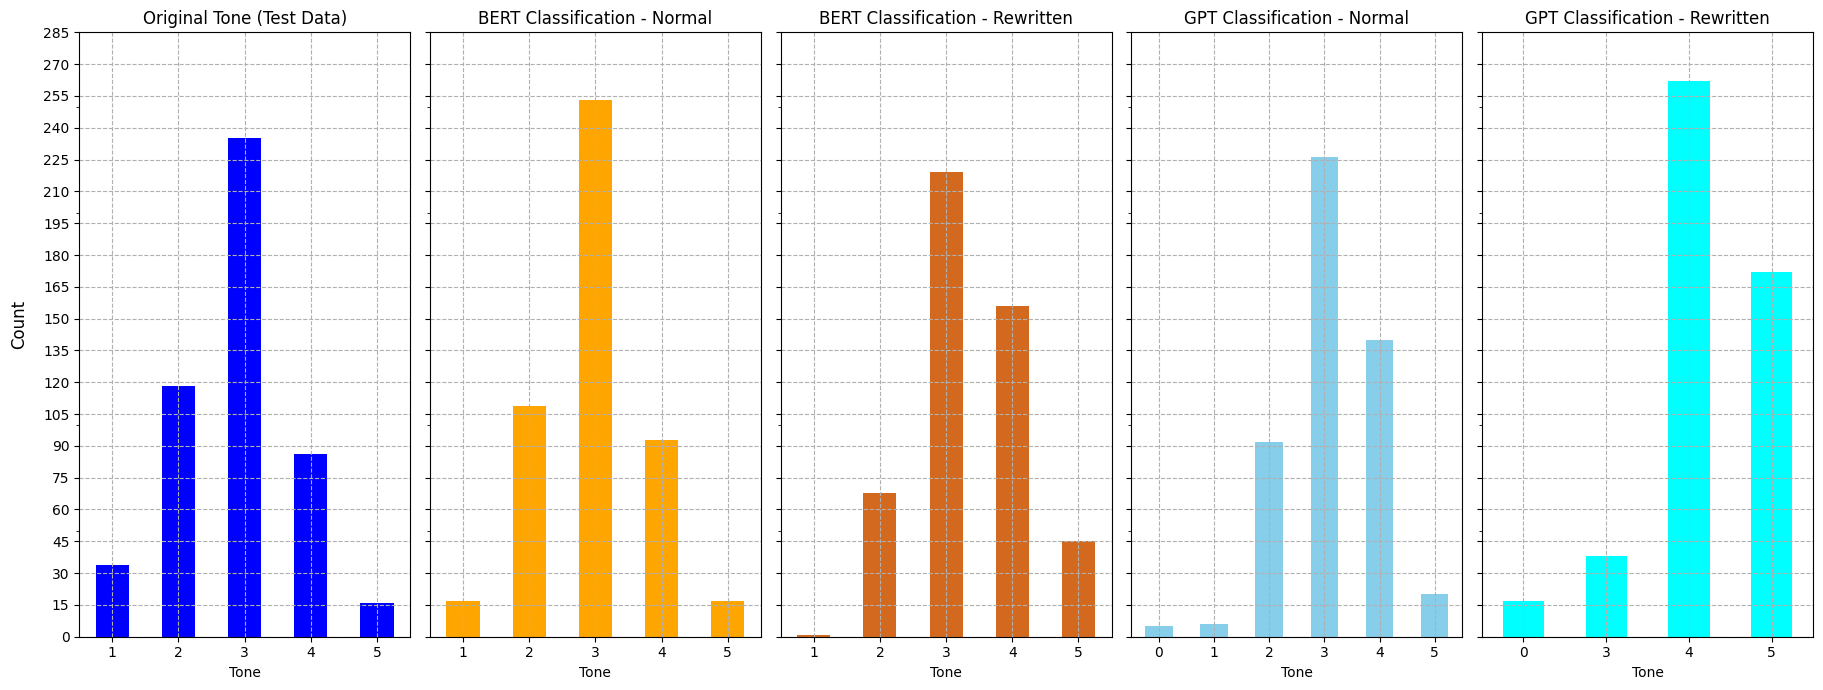

In [205]:
# Histogram of predicted labels:
# df5['GptClassification:'].value_counts().sort_index().plot(kind='bar')
# plt.title('GPT Classification from Rewritten')
# plt.xticks(ticks=[0, 1, 2, 3, 4], rotation=0)
# plt.xlabel('Tone')
# plt.grid(ls='--', alpha=0.7)
# plt.show()

# df5['rewrite_predicted_label'].value_counts().sort_index().plot(kind='bar')
# plt.title('BERT Classification from Rewritten')
# plt.xticks(ticks=[0, 1, 2, 3, 4], rotation=0)
# plt.xlabel('Tone')
# plt.grid(ls='--', alpha=0.7)
# plt.show()

alpha = 1

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(18, 7), sharey=True)

# Plot for BERT Classification - Normal
df5['bert_predicted_label'].astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('BERT Classification - Normal')
axes[1].tick_params(axis='x', rotation=0)  # Rotate xticks by 45 degrees
axes[1].set_xlabel('Tone')
axes[1].grid(ls='--', alpha=alpha)

# Plot for BERT Classification - Rewritten
df5['bert_rewritten_predicted_label'].astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[2], color='chocolate')
axes[2].set_title('BERT Classification - Rewritten')
axes[2].tick_params(axis='x', rotation=0)  # Rotate xticks by 45 degrees
axes[2].set_xlabel('Tone')
axes[2].grid(ls='--', alpha=alpha)

# Plot for GPT Classification - Normal
df5['GptClassification:'].astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[3], color='skyblue')
axes[3].set_title('GPT Classification - Normal')
axes[3].tick_params(axis='x', rotation=0)  # Rotate xticks by 45 degrees
axes[3].set_xlabel('Tone')
axes[3].grid(ls='--', alpha=alpha)

# Plot for GPT Classification - Rewritten
df5['GptClassification_rewritten:'].astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[4], color='cyan')
axes[4].set_title('GPT Classification - Rewritten')
axes[4].tick_params(axis='x', rotation=0)  # Rotate xticks by 45 degrees 
axes[4].set_xlabel('Tone')
axes[4].grid(ls='--', alpha=alpha)

df5['tone'].astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Original Tone (Test Data)')
axes[0].tick_params(axis='x', rotation=0)  # Rotate xticks by 45 degrees
axes[0].set_xlabel('Tone')
axes[0].grid(ls='--', alpha=alpha)

# Set shared y-axis label
fig.text(-0.01, 0.5, 'Count', rotation=90, fontsize=12)
plt.yticks(range(0, 286, 15))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Evaluation:

In [179]:
## Showing some progress with the rewritten comments:
# pprint(df5['bert_predicted_label'].value_counts().sort_index())
# pprint(df5['bert_rewritten_predicted_label'].value_counts().sort_index())

# Define the preset of acceptable labels
acceptable_labels = [0, 1, 2, 3, 4, 5]

# Convert the value counts to a full list with missing labels as zeros
l1 = df5['bert_predicted_label'].astype(int).value_counts().reindex(acceptable_labels, fill_value=0).sort_index().to_list()
l2 = df5['bert_rewritten_predicted_label'].astype(int).value_counts().reindex(acceptable_labels, fill_value=0).sort_index().to_list()
l3 = df5['GptClassification:'].astype(int).value_counts().reindex(acceptable_labels, fill_value=0).sort_index().to_list()
l4 = df5['GptClassification_rewritten:'].astype(int).value_counts().reindex(acceptable_labels, fill_value=0).sort_index().to_list()

# Debug print to check the lists
print("L1:", l1)
print("L2:", l2)
print("L3:", l3)
print("L4:", l4)

# Perform your analysis with no missing labels
# [0] represents an error in the GPT classification, only lost data for now, doesn't mean anything
print(
    '\n',
    'BERT:', '\n',
    'label 1:', round(l2[1] / l1[1], 4) * 100 if l1[1] != 0 else 0, '% of label 1, were classified as label 1 when rewritten (REDUCTION)', '\n',
    'label 2:', round(l2[2] / l1[2], 4) * 100 if l1[2] != 0 else 0, '% of label 2, were classified as label 2 when rewritten (REDUCTION)', '\n',
    'label 3:', round(l2[3] / l1[3], 4) * 100 if l1[3] != 0 else 0, '% of label 3, were classified as label 3 when rewritten (REDUCTION)', '\n',
    'label 4:', round(l2[4] / l1[4], 4) * 100 if l1[4] != 0 else 0, '% of label 4, were classified as label 4 when rewritten (INCREASE)', '\n',
    'label 5:', round(l2[5] / l1[5], 4) * 100 if l1[5] != 0 else 0, '% of label 5, were classified as label 5 when rewritten (INCREASE)', '\n',
    'GPT Classifier:', '\n',
    'label 1:', round(l4[1] / l3[1], 4) * 100 if l3[1] != 0 else 0, '% of label 1, were classified as label 1 when rewritten (REDUCTION)', '\n',
    'label 2:', round(l4[2] / l3[2], 4) * 100 if l3[2] != 0 else 0, '% of label 2, were classified as label 2 when rewritten (REDUCTION)', '\n',
    'label 3:', round(l4[3] / l3[3], 4) * 100 if l3[3] != 0 else 0, '% of label 3, were classified as label 3 when rewritten (REDUCTION)', '\n',
    'label 4:', round(l4[4] / l3[4], 4) * 100 if l3[4] != 0 else 0, '% of label 4, were classified as label 4 when rewritten (INCREASE)', '\n',
    'label 5:', round(l4[5] / l3[5], 4) * 100 if l3[5] != 0 else 0, '% of label 5, were classified as label 5 when rewritten (HUGE INCREASE)'
)

L1: [0, 17, 109, 253, 93, 17]
L2: [0, 1, 68, 219, 156, 45]
L3: [5, 6, 92, 226, 140, 20]
L4: [17, 0, 0, 38, 262, 172]

 BERT: 
 label 1: 5.88 % of label 1, were classified as label 1 when rewritten (REDUCTION) 
 label 2: 62.39 % of label 2, were classified as label 2 when rewritten (REDUCTION) 
 label 3: 86.56 % of label 3, were classified as label 3 when rewritten (REDUCTION) 
 label 4: 167.74 % of label 4, were classified as label 4 when rewritten (INCREASE) 
 label 5: 264.71 % of label 5, were classified as label 5 when rewritten (INCREASE) 
 GPT Classifier: 
 label 1: 0.0 % of label 1, were classified as label 1 when rewritten (REDUCTION) 
 label 2: 0.0 % of label 2, were classified as label 2 when rewritten (REDUCTION) 
 label 3: 16.81 % of label 3, were classified as label 3 when rewritten (REDUCTION) 
 label 4: 187.14 % of label 4, were classified as label 4 when rewritten (INCREASE) 
 label 5: 860.0 % of label 5, were classified as label 5 when rewritten (HUGE INCREASE)


In [218]:
## Precision, Recall, F1 and Accuracy:

## True labels
y_true = df5['tone'].astype(int)     

## BERT predictions
y_pred = df5['bert_predicted_label'].astype(int)
y_pred_gpt = df5['GptClassification:'].astype(int)

# Average precision and recall:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
accuracy_score_fraction = accuracy_score(y_true, y_pred) ## How many correct predictions were made - 'raw'
# ----
precision_gpt = precision_score(y_true, y_pred_gpt, average='macro')
recall_gpt = recall_score(y_true, y_pred_gpt, average='macro')
f1_macro_gpt = f1_score(y_true, y_pred_gpt, average='macro')
accuracy_score_fraction_gpt = accuracy_score(y_true, y_pred_gpt) ## How many correct predictions were made - 'raw'


# Compute precision and recall for each class:
precision_per_class_bert = precision_score(y_true, y_pred, average=None)
recall_per_class_bert = recall_score(y_true, y_pred, average=None)
f1_per_class_bert = f1_score(y_true, y_pred, average=None)
# ----
precision_per_class_gpt = precision_score(y_true, y_pred_gpt, average=None)
recall_per_class_gpt = recall_score(y_true, y_pred_gpt, average=None)
f1_per_class_gpt = f1_score(y_true, y_pred_gpt, average=None)

# Display average precision and recall
print('\n','BERT Classification metrics:')
print('Avg Precision:', round(precision, 3), '\n',
      'Avg Recall:', round(recall, 3), '\n',
      'F1 Macro:', round(f1_macro, 3), '\n',
      'Accuracy:', round(accuracy_score_fraction, 3)
    )
# Display precision and recall for each class
for cls, (prec, rec, f1) in enumerate(zip(precision_per_class_bert, recall_per_class_bert, f1_per_class_bert), start=1):
    print(f'Class {cls} - Precision: {round(prec, 3):.3f}, Recall: {round(rec, 3):.3f}, F1: {round(f1, 3):.3f}')
    
print('\n','GPT Classification metrics:')
print(
    'Avg Precision:', round(precision_gpt, 3), '\n',
      'Avg Recall:', round(recall_gpt, 3), '\n',
      'F1 Macro:', round(f1_macro_gpt, 3), '\n',
      'Accuracy:', round(accuracy_score_fraction_gpt, 3)
    )
for cls, (prec, rec, f1) in enumerate(zip(precision_per_class_gpt, recall_per_class_gpt, f1_per_class_gpt), start=0):
    print(f'Class {cls} - Precision: {round(prec, 3):.3f}, Recall: {round(rec, 3):.3f}, F1: {round(f1, 3):.3f}'.format())
print('\n')


 BERT Classification metrics:
Avg Precision: 0.588 
 Avg Recall: 0.547 
 F1 Macro: 0.557 
 Accuracy: 0.611
Class 1 - Precision: 0.588, Recall: 0.294, F1: 0.392
Class 2 - Precision: 0.523, Recall: 0.483, F1: 0.502
Class 3 - Precision: 0.696, Recall: 0.749, F1: 0.721
Class 4 - Precision: 0.484, Recall: 0.523, F1: 0.503
Class 5 - Precision: 0.647, Recall: 0.688, F1: 0.667

 GPT Classification metrics:
Avg Precision: 0.311 
 Avg Recall: 0.252 
 F1 Macro: 0.253 
 Accuracy: 0.429
Class 0 - Precision: 0.000, Recall: 0.000, F1: 0.000
Class 1 - Precision: 0.500, Recall: 0.088, F1: 0.150
Class 2 - Precision: 0.446, Recall: 0.347, F1: 0.390
Class 3 - Precision: 0.575, Recall: 0.553, F1: 0.564
Class 4 - Precision: 0.243, Recall: 0.395, F1: 0.301
Class 5 - Precision: 0.100, Recall: 0.125, F1: 0.111




c:\Dev\mestrado\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Dev\mestrado\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Guto: Looking at this results (from cell above):
```python
BERT Classification metrics:
Avg Precision: 0.588 
Avg Recall: 0.547 
F1 Macro: 0.557 
Accuracy: 0.611
Class 1 - Precision: 0.588, Recall: 0.294, F1: 0.392
Class 2 - Precision: 0.523, Recall: 0.483, F1: 0.502
Class 3 - Precision: 0.696, Recall: 0.749, F1: 0.721
Class 4 - Precision: 0.484, Recall: 0.523, F1: 0.503
Class 5 - Precision: 0.647, Recall: 0.688, F1: 0.667

GPT Classification metrics:
Avg Precision: 0.311 
Avg Recall: 0.252 
F1 Macro: 0.253 
Accuracy: 0.429
Class 0 - Precision: 0.000, Recall: 0.000, F1: 0.000
Class 1 - Precision: 0.500, Recall: 0.088, F1: 0.150
Class 2 - Precision: 0.446, Recall: 0.347, F1: 0.390
Class 3 - Precision: 0.575, Recall: 0.553, F1: 0.564
Class 4 - Precision: 0.243, Recall: 0.395, F1: 0.301
Class 5 - Precision: 0.100, Recall: 0.125, F1: 0.111
```
Some points:
- GPT depends on the prompt,
- GPT got a lot of wrong predictions, even if the number of predictions looks similar to the original tone.

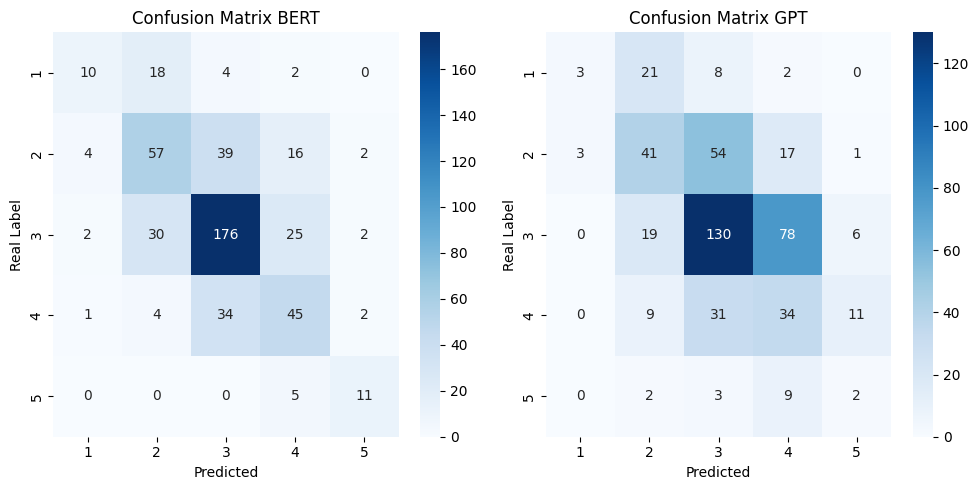

In [224]:
## Confusion Matrixes:

# Define the range of labels explicitly (1 to 5)
label_range = [1, 2, 3, 4, 5]

# Create a subplot with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Generate the confusion matrix for BERT
conf_matrix_bert = confusion_matrix(
    df5['tone'].astype(int), 
    df5['bert_predicted_label'].astype(int), 
    labels=label_range
)

# Plot the confusion matrix for BERT
sns.heatmap(conf_matrix_bert, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_range, yticklabels=label_range, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real Label')
axes[0].set_title('Confusion Matrix BERT')

# Generate the confusion matrix for GPT
conf_matrix_gpt = confusion_matrix(
    df5['tone'].astype(int), 
    df5['GptClassification:'].astype(int), 
    labels=label_range
)

# Plot the confusion matrix for GPT
sns.heatmap(conf_matrix_gpt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_range, yticklabels=label_range, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real Label')
axes[1].set_title('Confusion Matrix GPT')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## Conclusões Parciais e Lista de Tarefas:

---
**Observações (conclusões parciais):**
- Dataset está com uns comentarios negativos que poderiam ser classificados como Neutro+, pode estar trazendo problemas de viés.
- Presença de ironia em muitos comentários, o que pode confundir a identificação de politeness ("the writing is often arrestingly pedestrian"), GPT a princípio lidou bem com alguns desses casos que eu analisei manualmente (ainda tenho que avaliar mais um ou dois para isso). 
- Questão de desbalanceamento de classes pode ter trazido uma questão de viés forte também (classe 3 como muito predominante).
- Prompt do classificador GPT influencia bastante na classificação, podendo ser um ponto de melhoria neste classificador.

<br>

**Conversa com a Karin:** 
- Intro: qual é a proposta do trabalho - verificação do chat gpt como reescrita de comentarios para mais polite, e classificação de politeness. Análise de erros do modelo.
    - Avaliar a performance dos meus `3` modelos classificadores
    - Avaliação da Reescrita, quais são os casos que ele não escreve bem.
    - Anotar manualmente essa reescrita, comparar com a classificação.
- Conclusões: 
    - Comparações entre anotação manual e resultados dos classificadores.

**Lista de tarefas compilada (Em ordem):**
- [<font color='greenyellow'>**Done**</font>] Tem que rodar para todos os casos, colocar os resultados disso e também os comentarios reescritos em 2 colunas no dataframe de teste 
- [<font color='greenyellow'>**Done**</font>] Depois rodar a classificação com o GPT mesmo, e colocar o resultado numa outra coluna no mesmo dataset. 
- [<font color='greenyellow'>**Done**</font>] Formalizar métricas de avaliação, terminar essa parte para depois que treinar outros modelos só replicas as métricas. (Avaliar com métricas de classificação multi-classe)
- [<font color='deeppink'>**Think**</font>] Alterar a reescrita polite para apenas reescrever o que é 1 e 2, objetivo é tentar tranformar isso em 4 ou 5.
    - Ver sobre fazer anotação manual destes novos reescritos (pessoal da poatek)
- Treinar o modelo de classificação clássico (NB ou RF) com 5 labels e com 3 labels.
- Treinar um modelo BERT só com 3 classes, dai fazer TUDO igual msm coisa mas com esse modelo (adaptar os resultados para 1, 2, 3 tendo 1, 2, 3, 4, 5) \
    - Re-Treinar o BERT só com 3 labels.
- Juntar Labels [1 e 2], [4 e 5], Escrever métricas de avaliação para o classificador BERT e GPT baseadas nessa junção, ver se teve melhora.
- Avaliar com todas as métricas de performance já estabelecidas anteriormente.
- Transformar o que é 3 em Polite. (finalidade: ver se a reescrita realmente foi eficaz ou não, caso muitos foram para 4 ou 5, ou no caso Polite)
    - Ver sobre fazer anotação/avaliação manual destes novos reescritos (pessoal da poatek)
- Avaliar quais são os casos de erro. 
    - Quais são os maiores motivos de erro: ironia/qual label ele mais erra/as frases têm algo em comum... ?

### Reescrita Polite só dos tones 1 e 2:

In [233]:
df5.loc[(df5['tone'].astype(int) == 1) | (df5['tone'].astype(int) == 2)][['tone', 'bert_predicted_label', 'GptClassification:', 'bert_rewritten_predicted_label', 'GptClassification_rewritten:']]
## TODO: pensar um pouco o que fazer e avaliar a partir daqui, n sei mt bem o que avaliar

,tone,bert_predicted_label,GptClassification:,bert_rewritten_predicted_label,GptClassification_rewritten:
642,2,4,3,3,4
506,2,2,2,2,4
191,1,1,3,4,5
719,2,3,1,4,3
1148,2,2,2,3,4
...,...,...,...,...,...
130,2,2,2,2,4
347,1,2,2,2,4
1063,2,2,3,2,4
1686,2,2,3,3,4


### Multinomial Naive Bayes:


In [264]:
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(local_path)

# Tokenize the text
def tokenize_texts(texts):
    return [" ".join(tokenizer.tokenize(text)) for text in texts]

tokenized_texts = tokenize_texts(X_train)

# Convert tokenized texts to feature vectors (Bag-of-Words or TF-IDF)
vectorizer = TfidfVectorizer()  # Or CountVectorizer() for BoW
X_train_features = vectorizer.fit_transform(tokenized_texts)

# Train the MNB model
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train_features, y_train)

# Tokenize and vectorize test data
tokenized_test = tokenize_texts(X_test)
X_test_features = vectorizer.transform(tokenized_test)

# Predict and evaluate
y_pred = clf.predict(X_test_features)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.15      0.23        34
           1       0.43      0.35      0.38       118
           2       0.56      0.78      0.65       235
           3       0.39      0.22      0.28        86
           4       0.50      0.25      0.33        16

    accuracy                           0.52       489
   macro avg       0.49      0.35      0.38       489
weighted avg       0.50      0.52      0.48       489



In [ ]:
## Resampling attemptive for Naive Bayes model:

# Apply SMOTE to the training data
smote=SMOTE(random_state=42)
X_resampled, y_resampled =  smote.fit_resample(X_train_features, y_train)

## Fit again the model but with resampled data
re_clf = MultinomialNB(alpha=0.1) # alpha = 0.1 was due gridsearch realized in another parallel study
re_clf.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred_re = re_clf.predict(X_test_features)
print(classification_report(y_test, y_pred_re))

              precision    recall  f1-score   support

           0       0.28      0.32      0.30        34
           1       0.47      0.43      0.45       118
           2       0.66      0.53      0.58       235
           3       0.32      0.44      0.37        86
           4       0.18      0.38      0.24        16

    accuracy                           0.47       489
   macro avg       0.38      0.42      0.39       489
weighted avg       0.51      0.47      0.48       489



In [275]:
X_resampled

<4410x4671 sparse matrix of type '<class 'numpy.float64'>'
	with 122137 stored elements in Compressed Sparse Row format>

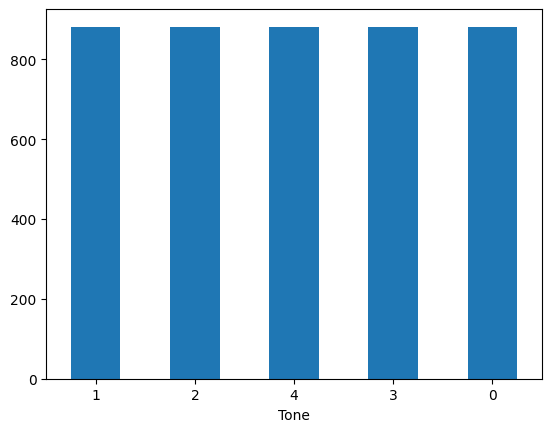

In [256]:
y_resampled.value_counts().plot(kind='bar')
plt.tick_params(axis='x', rotation=0)

### 3 Label Classification:

In [291]:
# 3 Labels: [1] = Impolite/Highly Impolite, [2] = Neutral, [3] = Polite/Highly Polite
TargetDf2['Simplf_Tone'] = TargetDf2['Tone'].apply(lambda x: 1 if x == 1 or x == 2 else 2 if x == 3 else 3)
pprint(TargetDf2['Simplf_Tone'].value_counts().sort_index())
pprint(TargetDf2['Tone'].value_counts().sort_index())

Simplf_Tone
1     764
2    1117
3     560
Name: count, dtype: int64
Tone
1     197
2     567
3    1117
4     459
5     101
Name: count, dtype: int64


In [302]:
X_train, X_test, y_train, y_test = train_test_split(TargetDf2['TransformedReview'], TargetDf2['Simplf_Tone'], test_size=0.2, random_state=42)

y_train = y_train - 1
y_test = y_test - 1

In [308]:
## BERT Classifier, Train:

model_base = 'bert-base-uncased'                          ## >>> Uncomment this in case of fine-tuning the model (commented here to avoid running everything)
tokenizer2 = AutoTokenizer.from_pretrained(model_base) 

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=128,  # Adjust this as needed
            return_tensors="pt",
        )
        # Return a dictionary with the required fields
        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),  # Label tensor
        }

# Prepare the datasets
train_dataset_3labels = CustomDataset(X_train.tolist(), y_train.tolist(), tokenizer2)
test_dataset_3labels = CustomDataset(X_test.tolist(), y_test.tolist(), tokenizer2)
data_collator_3labels = DataCollatorWithPadding(tokenizer=tokenizer2)

output_dir = './bert_3label'
training_args = TrainingArguments(
    output_dir=output_dir,                    # Nome e diretório do modelo final
    num_train_epochs=3,                       # Número de épocas
    per_device_train_batch_size=8,            # Tamanho do lote (batch) por GPU
    per_device_eval_batch_size=8,             # Tamanho do lote (batch) para validação por GPU
    weight_decay=0.01,                        # Força de decaimento
    logging_dir='./logs',                     # Pasta para salvar logs
    logging_steps=100,                        # Logar a cada N etapas
    eval_strategy='steps',                    # Estratégia de avaliação
    eval_steps=200,                           # Rodar avaliação a cada N etapas
    save_total_limit=2,                       # Salvar apenas os ultimos N checkpoints
    save_steps=200,                           # Salvar checkpoint a cada N etapas.
    load_best_model_at_end=True,              # Carregar o melhor modelo no fim
    metric_for_best_model='accuracy',         # Métrica para encontrar o melhor modelo
)

model_3labels = AutoModelForSequenceClassification.from_pretrained(model_base, num_labels=3)

metric2 = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric2.compute(predictions=predictions, references=labels)

trainer2 = Trainer(
    model_3labels,
    training_args,
    train_dataset=train_dataset_3labels,
    eval_dataset=test_dataset_3labels,
    data_collator=data_collator_3labels,
    processing_class=tokenizer2,
    compute_metrics=compute_metrics,
)

trainer2.train() ## ~28-31 min

# simple_date = date.today().strftime('%d%m%y')
trainer2.save_model('bert-treined_3labels')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/732 [00:00<?, ?it/s]

{'loss': 0.9833, 'grad_norm': 5.55402135848999, 'learning_rate': 4.316939890710383e-05, 'epoch': 0.41}
{'loss': 0.9312, 'grad_norm': 22.300138473510742, 'learning_rate': 3.633879781420765e-05, 'epoch': 0.82}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.8851929306983948, 'eval_accuracy': 0.6339468302658486, 'eval_runtime': 36.9264, 'eval_samples_per_second': 13.243, 'eval_steps_per_second': 1.679, 'epoch': 0.82}
{'loss': 0.7894, 'grad_norm': 13.957415580749512, 'learning_rate': 2.9508196721311478e-05, 'epoch': 1.23}
{'loss': 0.6775, 'grad_norm': 14.270018577575684, 'learning_rate': 2.2677595628415303e-05, 'epoch': 1.64}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.8322334289550781, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 36.8145, 'eval_samples_per_second': 13.283, 'eval_steps_per_second': 1.684, 'epoch': 1.64}
{'loss': 0.6418, 'grad_norm': 5.558323860168457, 'learning_rate': 1.5846994535519128e-05, 'epoch': 2.05}
{'loss': 0.4111, 'grad_norm': 6.908438205718994, 'learning_rate': 9.016393442622952e-06, 'epoch': 2.46}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.9981352090835571, 'eval_accuracy': 0.6646216768916156, 'eval_runtime': 40.2883, 'eval_samples_per_second': 12.138, 'eval_steps_per_second': 1.539, 'epoch': 2.46}
{'loss': 0.4113, 'grad_norm': 17.019338607788086, 'learning_rate': 2.185792349726776e-06, 'epoch': 2.87}
{'train_runtime': 1926.7341, 'train_samples_per_second': 3.039, 'train_steps_per_second': 0.38, 'train_loss': 0.6798012855925847, 'epoch': 3.0}


In [309]:
## Option: Load from local (already trained)
local_path = 'bert-treined_3labels'
# model_trained_3labels = AutoModelForSequenceClassification.from_pretrained(local_path)

model_trained_3labels = trainer2.model
tokenizer2 = AutoTokenizer.from_pretrained(local_path)

# New Prediction
pipe_3labels = TextClassificationPipeline(model=trainer2.model, tokenizer=tokenizer2)

# Sample prediction:
prediction = pipe_3labels("This article looks like shit", top_k=None)
prediction

[{'label': 'LABEL_0', 'score': 0.8649019002914429},
 {'label': 'LABEL_1', 'score': 0.11038564145565033},
 {'label': 'LABEL_2', 'score': 0.02471250668168068}]

In [304]:
## GPT Classifier:

## Classify with GPT-4o:

def GptClassification_3labels(Sample: str):
    
    PromptClassify = [
            {"role": "system", "content":   "You are a helpful technical assistant,\
                                            specialist in non violent communication, politeness and all communication matters.\
                                            You are rating texts on a scale of 1 to 3 for politeness, from Impolite (1) to Polite (3), (2) would be for Neutral comments."}, 
            {"role": "user", "content":     "In a scale of 1, 2 or 3 classify the comment about it's Politeness.\
                                            In a json format: {'label':'_ClassificationResult_', 'explanation':'_Explanation_'} \
                                            Bring up the politeness rating of the comment at the _ClassificationResult_, then after a 2 line explanation why at the _Explanation_, \
                                            of this comment:"+Sample},
        ]
        
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages = PromptClassify,
        temperature = 0.1
        )

    # return completion1.choices[0].message.content, completion2.choices[0].message.content
    return completion.choices[0].message.content

## Function that returns a json from a string in json format
def SimpleFormatting(text):
    '''function that returns a json from a string in json format'''    
    json_string = text.strip('```json').strip()
    return json.loads(json_string)


# Cache results to avoid duplicate API calls
result_cache = {}

## Function to classify with GPT each review
def process_review(review):
    if review in result_cache:
        return result_cache[review]
    try:
        # Call the GPT classification API
        rank1 = GptClassification(review)
        rank1 = SimpleFormatting(rank1)
        result_cache[review] = rank1['label']
        return rank1['label']
    except Exception as e:
        print('Exception at json dump (moving forward):', e)
        return None
    
## Examples:
comment = "although finding novel gan applications is an exciting topic i am \
    not really convinced that ica with the proposed wasserstein gan based \
    technique fulfills this goal" 
# comment = "the writing is often arrestingly pedestrian"

# rewritten_comment = "while exploring novel gan applications is indeed an exciting topic i am not \
#     entirely convinced that the proposed ica with the wasserstein gan based \
#     technique fully achieves this objective."
# rewritten_comment = "The writing tends to be straightforward and uncomplicated."
    
rank = GptClassification_3labels(comment)
pprint(rank)
# print('\n')
# pprint(rank2)

('```json\n'
 '{\n'
 '  "label": "2",\n'
 '  "explanation": "The comment is neutral as it expresses a personal opinion '
 'without using impolite language. It acknowledges the excitement of the topic '
 'while expressing skepticism in a straightforward manner."\n'
 '}\n'
 '```')


In [310]:
## Multinomial Classifier:

# without resampling:

# Tokenize the text
def tokenize_texts(texts):
    return [" ".join(tokenizer.tokenize(text)) for text in texts] # By here I already have my tokenizer

tokenized_texts = tokenize_texts(X_train)

# Convert tokenized texts to feature vectors (Bag-of-Words or TF-IDF)
vectorizer = TfidfVectorizer()  # Or CountVectorizer() for BoW
X_train_features = vectorizer.fit_transform(tokenized_texts)

# Train the MNB model
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train_features, y_train)

# Tokenize and vectorize test data
tokenized_test = tokenize_texts(X_test)
X_test_features = vectorizer.transform(tokenized_test)

# Predict and evaluate
y_pred = clf.predict(X_test_features)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       152
           1       0.60      0.71      0.65       235
           2       0.47      0.34      0.40       102

    accuracy                           0.58       489
   macro avg       0.56      0.53      0.54       489
weighted avg       0.58      0.58      0.58       489



In [311]:
# with resampling:

# Apply SMOTE to the training data
smote=SMOTE(random_state=42)
X_resampled, y_resampled =  smote.fit_resample(X_train_features, y_train)

## Fit again the model but with resampled data
re_clf = MultinomialNB(alpha=0.1) # alpha = 0.1 was due gridsearch realized in another parallel study
re_clf.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred_re = re_clf.predict(X_test_features)
print(classification_report(y_test, y_pred_re))

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       152
           1       0.65      0.54      0.59       235
           2       0.39      0.53      0.45       102

    accuracy                           0.56       489
   macro avg       0.54      0.56      0.55       489
weighted avg       0.58      0.56      0.56       489



In [ ]:
## Falta só avaliar os modelos aqui, e escrever o relatório